In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

# Macro Features

In [6]:
df = pd.DataFrame()
path = '/Users/mac/Desktop/PycharmProjects/TAADL/input/Macro'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        print(name)
        if name == '.DS_Store':
            pass
        else:
            dataname = name.split('.')[0]
            exec(f'{dataname} = pd.read_csv(os.path.join(root, name),index_col="Date")')
            exec(f'{dataname}.index = pd.to_datetime({dataname}.index)')
            exec(f'df = pd.concat([df, {dataname}.iloc[:,:1]],axis=1)')
            

Russell2000.csv
US10Y.csv
Gold.csv
.DS_Store
USPAY.csv
USCPI.csv
Copper.csv
US3M.csv
DJIA.csv
US2Y.csv
USGDP.csv
JPY.csv
Oil.csv
SP500.csv


In [7]:
# cut past nan values and ffill values 
df = df.loc['2001-01-01':,:].ffill().dropna(axis=0)

In [8]:
# feature engineering
macro_data = df.loc[:,['JPY','US10Y','Gold','Copper','Oil','SP500','US_Pay','US_GDP','US_CPI']]
macro_data['10Y-2YSpread']  = df['US10Y'] - df['US2Y']
macro_data['2Y-3MSpread']   = df['US2Y'] - df['US3M']
macro_data['Cop/Gold']      = df['Copper'].div(df['Gold'])
macro_data['SP500/DJIA']    = df['SP500'].div(df['DJIA'])
macro_data['SP500/Rus2000'] = df['SP500'].div(df['Russell2000'])

# ETF Features

In [9]:
df_etf = pd.DataFrame()
etf_names = []
path = '/Users/mac/Desktop/PycharmProjects/TAADL/input/etf'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if name == '.DS_Store':
            pass
        else:
            dataname = name.split(' ')[0]
            etf_names.append(dataname)
            exec(f'{dataname} = pd.read_csv(os.path.join(root, name),index_col="Date")')
            exec(f'{dataname}.index = pd.to_datetime({dataname}.index)')
            exec(f'df_etf = pd.concat([df_etf, {dataname}[["Price"]]],axis=1)')

df_etf.columns = etf_names

In [10]:
df_etf.isna().sum()

VTI       30
BNDX    3038
VNQ      828
VWOB    3039
VGK      940
VWO      939
BND     1491
VNQI    2389
dtype: int64

In [11]:
# MICE Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr, missing_values=np.nan, max_iter=200, verbose=1, skip_complete=True, imputation_order='roman')

In [12]:
df_etf.loc['2016-01-01':'2022-02-23'] = df_etf.loc['2016-01-01':'2022-02-23'].ffill()
df_etf = df_etf.loc['2006-01-01':'2022-02-23']

In [13]:
df_ret = df_etf.copy().pct_change()

df_ret_imputed = imp.fit_transform(df_ret.iloc[1:])
df_ret_imputed = pd.DataFrame(df_ret_imputed, columns=df_etf.columns, index=df_etf.index[1:])

[IterativeImputer] Completing matrix with shape (4093, 8)
[IterativeImputer] Change: 0.19470823142394578, scaled tolerance: 0.00020282258064516112 
[IterativeImputer] Change: 0.01948284068311424, scaled tolerance: 0.00020282258064516112 
[IterativeImputer] Change: 0.0012503315637924471, scaled tolerance: 0.00020282258064516112 
[IterativeImputer] Change: 8.446620215763387e-05, scaled tolerance: 0.00020282258064516112 
[IterativeImputer] Early stopping criterion reached.


In [14]:
ret_cumprod = df_ret_imputed.add(1).cumprod(axis=0)

# find the index of non NA entry
bndx_fd = df_etf['BNDX'].first_valid_index() 
vwob_fd = df_etf['VWOB'].first_valid_index() 
bnd_fd  = df_etf['BND'].first_valid_index() 
vnqi_fd = df_etf['VNQI'].first_valid_index() 

# re-scale the data to make the first non-NA to be 1.
ret_cumprod['BNDX'] = ret_cumprod['BNDX'].div(ret_cumprod.loc[bndx_fd,'BNDX'])
ret_cumprod['VWOB'] = ret_cumprod['VWOB'].div(ret_cumprod.loc[vwob_fd,'VWOB'])
ret_cumprod['BND']  = ret_cumprod['BND'].div(ret_cumprod.loc[bnd_fd,'BND'])
ret_cumprod['VNQI'] = ret_cumprod['VNQI'].div(ret_cumprod.loc[vnqi_fd,'VNQI'])

# replace the empty data with synthetic price generated by imputed return data
df_etf.loc[:bndx_fd,'BNDX'] = ret_cumprod.loc[:bndx_fd,'BNDX'] * df_etf.loc[bndx_fd,'BNDX']
df_etf.loc[:vwob_fd,'VWOB'] = ret_cumprod.loc[:vwob_fd,'VWOB'] * df_etf.loc[vwob_fd,'VWOB']
df_etf.loc[:bnd_fd,'BND']   = ret_cumprod.loc[:bnd_fd,'BND'] * df_etf.loc[bnd_fd,'BND']
df_etf.loc[:vnqi_fd,'VNQI'] = ret_cumprod.loc[:vnqi_fd,'VNQI'] * df_etf.loc[vnqi_fd,'VNQI']

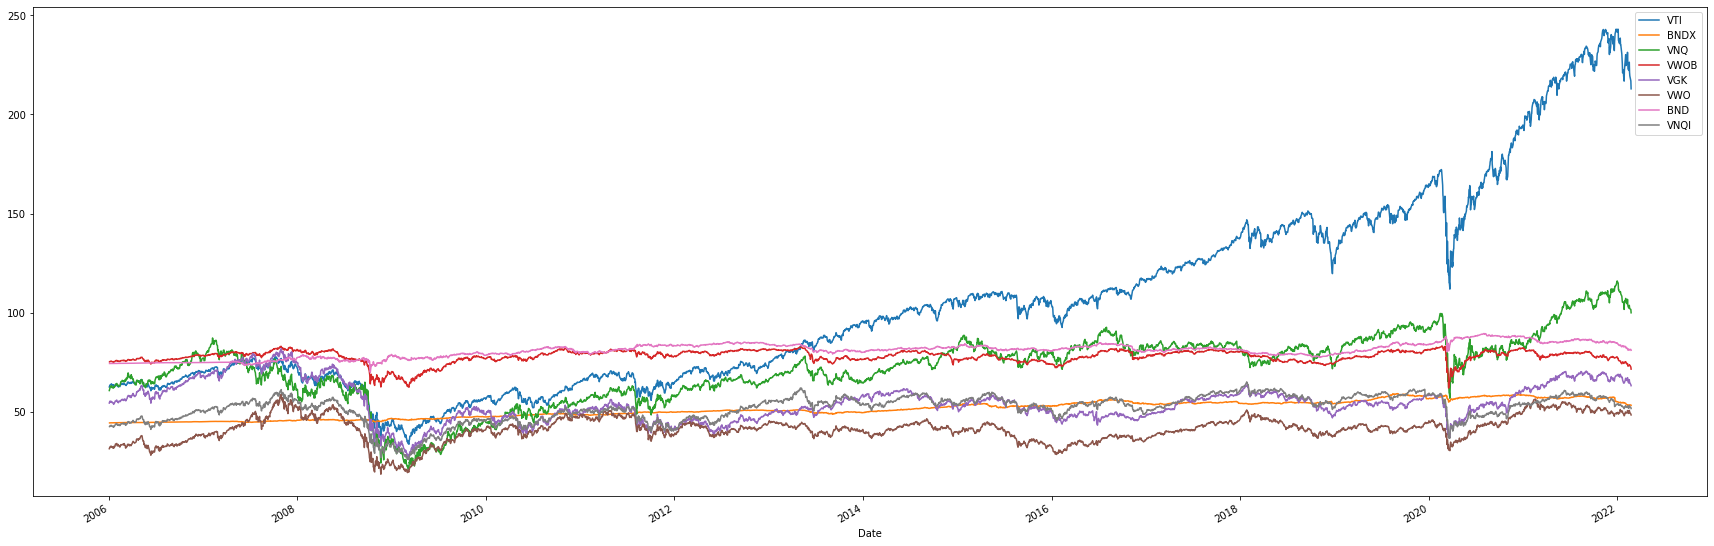

In [16]:
df_etf.plot(figsize=(30,10))
df_etf.to_csv('/Users/mac/Desktop/PycharmProjects/TAADL/input/prices.csv')

In [17]:
# Now create features related to price data
df_etf_30  = df_etf/df_etf.shift(30) - 1
df_etf_60  = df_etf/df_etf.shift(60) - 1
df_etf_130 = df_etf/df_etf.shift(130) - 1
df_etf_260 = df_etf/df_etf.shift(260) - 1

# rename columns that matches 
df_etf_30  = df_etf_30.add_suffix('_ret030')
df_etf_60  = df_etf_60.add_suffix('_ret060')
df_etf_130 = df_etf_130.add_suffix('_ret130')
df_etf_260 = df_etf_260.add_suffix('_ret260')

# concatenate all etf return features
price_data = pd.concat([df_etf_30, df_etf_60, df_etf_130, df_etf_260],axis=1)
price_data = price_data.sort_index(axis=1)

In [18]:
macro_data.index = pd.to_datetime(macro_data.index)
price_data.index = pd.to_datetime(price_data.index)

# find dates that both data exist
index = pd.to_datetime(np.intersect1d(macro_data.index, price_data.index))

# concatenate price and macro features
feature = pd.concat([price_data.loc[index,:], macro_data.loc[index,:]], axis=1)
feature = feature.dropna(axis=0)

In [20]:
feature.to_csv('/Users/mac/Desktop/PycharmProjects/TAADL/input/features.csv')
feature.head()

,BNDX_ret030,BNDX_ret060,BNDX_ret130,BNDX_ret260,BND_ret030,BND_ret060,BND_ret130,BND_ret260,VGK_ret030,VGK_ret060,...,Oil,SP500,US_Pay,US_GDP,US_CPI,10Y-2YSpread,2Y-3MSpread,Cop/Gold,SP500/DJIA,SP500/Rus2000
2007-01-18,0.001124,0.003436,0.006991,0.014936,0.000652,0.001243,0.002075,0.006830,0.003104,0.052411,...,50.48,1426.37,137249.0,0.779358,2.54065,-0.140,-0.213,0.003950,0.113493,1.809816
2007-01-19,0.001094,0.003822,0.007210,0.014777,0.000790,0.001187,0.001771,0.006768,0.006454,0.057328,...,51.99,1430.50,137249.0,0.779358,2.54065,-0.149,-0.179,0.003937,0.113843,1.838382
2007-01-22,0.001374,0.003600,0.007369,0.014703,0.000930,0.001348,0.001741,0.007020,-0.006114,0.052737,...,51.13,1422.95,137249.0,0.779358,2.54065,-0.154,-0.195,0.003978,0.114044,1.812767
2007-01-23,0.001580,0.003839,0.007256,0.014417,0.000907,0.001375,0.001701,0.007063,0.006741,0.061168,...,55.04,1427.99,137249.0,0.779358,2.54065,-0.144,-0.160,0.003979,0.113931,1.836430
2007-01-24,0.002012,0.003991,0.006842,0.014332,0.000637,0.001256,0.001589,0.006941,0.008007,0.060499,...,55.37,1440.13,137249.0,0.779358,2.54065,-0.123,-0.182,0.003996,0.114099,1.830852
